vertical cumulative heat budget

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
from xhistogram.xarray import histogram
import pandas as pd
import cosima_cookbook as cc
from collections import OrderedDict


In [2]:
from dask.distributed import Client


In [3]:
client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:38165 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 24 Memory: 103.08 GB


In [4]:
session = cc.database.create_session('/scratch/e14/cy8964/access-om2/archive/databases/1deg_jra55_ryf_experiments.db')

In [5]:
exptdict = OrderedDict([
    ('Control',  {'expt':'1deg_jra55_ryf_RCPcont'}),
    ('Warming',  {'expt':'1deg_jra55_ryf_RCPwarmhumid'}),
    ('Warming x2',  {'expt':'1deg_jra55_ryf_RCPwarmhumid2x'}),
    ('Cooling',  {'expt':'1deg_jra55_ryf_RCPcoolhumid'}),
    ('Cooling x2',  {'expt':'1deg_jra55_ryf_RCPcoolhumid2x'}),
    ('Warming w/o humidity',  {'expt':'1deg_jra55_ryf_rcpwarm'}),
    ('Cooling w/o humidity',  {'expt':'1deg_jra55_ryf_rcpcool'}),
    ('Cooling w/o humidity2', {'expt':'1deg_jra55_ryf_RCPcool'}),
    ('Windup', {'expt':'1deg_jra55_ryf_red3DSK_C9'})

])
lim = {'Warming': 1.5,'Warming x2': 3,'Cooling':1.5,'Cooling x2':3}
label = {'Warming': 'Warming','Warming x2': 'Warming x2','Cooling':'Cooling','Cooling x2':'Cooling x2'}


In [6]:
def vertical_heat_budget_terms(ekey):
    expt = exptdict[ekey]['expt']
    temp_tendency = cc.querying.getvar(expt, 'temp_tendency', session, ncfile = 'ocean_heat.nc')
    area_t = cc.querying.getvar(expt, 'area_t', session, ncfile = 'ocean_grid.nc', n=-1)
    dyt = cc.querying.getvar(expt, 'dyt', session, ncfile = 'ocean_grid.nc', n=-1)
    dxt= cc.querying.getvar(expt, 'dyt', session, ncfile = 'ocean_grid.nc', n=-1)
    dzt = cc.querying.getvar(expt, 'dzt', session, ncfile = 'ocean_heat.nc')
    adv = cc.querying.getvar(expt, 'temp_advection', session)
    sw_heat =  cc.querying.getvar(expt, 'sw_heat', session)
    temp_vdiffuse_diff_cbt =   cc.querying.getvar(expt, 'temp_vdiffuse_diff_cbt', session, ncfile = 'ocean_heat.nc')
    temp_submeso =   cc.querying.getvar(expt, 'temp_submeso', session, ncfile = 'ocean_heat.nc')
    mixdownslope_temp = cc.querying.getvar(expt, 'mixdownslope_temp', session, ncfile = 'ocean_heat.nc')
    neutral_gm_temp = cc.querying.getvar(expt, 'neutral_gm_temp', session, ncfile = 'ocean_heat.nc')
    temp_vdiffuse_sbc= cc.querying.getvar(expt, 'temp_vdiffuse_sbc', session, ncfile = 'ocean_heat.nc')
    temp_nonlocal_KPP = cc.querying.getvar(expt, 'temp_nonlocal_KPP', session, ncfile = 'ocean_heat.nc')
    neutral_diffusion_temp= cc.querying.getvar(expt, 'neutral_diffusion_temp', session, ncfile = 'ocean_heat.nc')
    temp_rivermix= cc.querying.getvar(expt, 'temp_rivermix', session, ncfile = 'ocean_heat.nc')
    temp_vdiffuse_k33= cc.querying.getvar(expt, 'temp_vdiffuse_k33', session, ncfile = 'ocean_heat.nc')
    frazil_3d= cc.querying.getvar(expt, 'frazil_3d', session, ncfile = 'ocean_heat.nc')
    sfc_hflux_pme = cc.querying.getvar(expt, 'sfc_hflux_pme', session, ncfile = 'ocean_heat.nc')
    temp = cc.querying.getvar(expt, 'temp', session, ncfile = 'ocean_heat.nc')
    temp_sigma_diff = cc.querying.getvar(expt, 'temp_sigma_diff', session, ncfile = 'ocean_heat.nc')
    
    advection = adv + neutral_gm_temp + temp_submeso
    vertical_mixing = temp_vdiffuse_diff_cbt + temp_nonlocal_KPP + mixdownslope_temp + temp_sigma_diff
    along_iso_mixing = neutral_diffusion_temp + temp_vdiffuse_k33
    surface_forcing = frazil_3d + temp_rivermix+ sw_heat + temp_vdiffuse_sbc
    
    new_surf = xr.concat([sfc_hflux_pme.assign_coords(st_ocean = surface_forcing.isel(st_ocean=0).st_ocean.values),(0*surface_forcing).isel(st_ocean = np.arange(1,50))], dim = 'st_ocean')
    surface_forcing_combined = surface_forcing+new_surf
    
    return temp_tendency, advection, vertical_mixing, along_iso_mixing, surface_forcing_combined, area_t

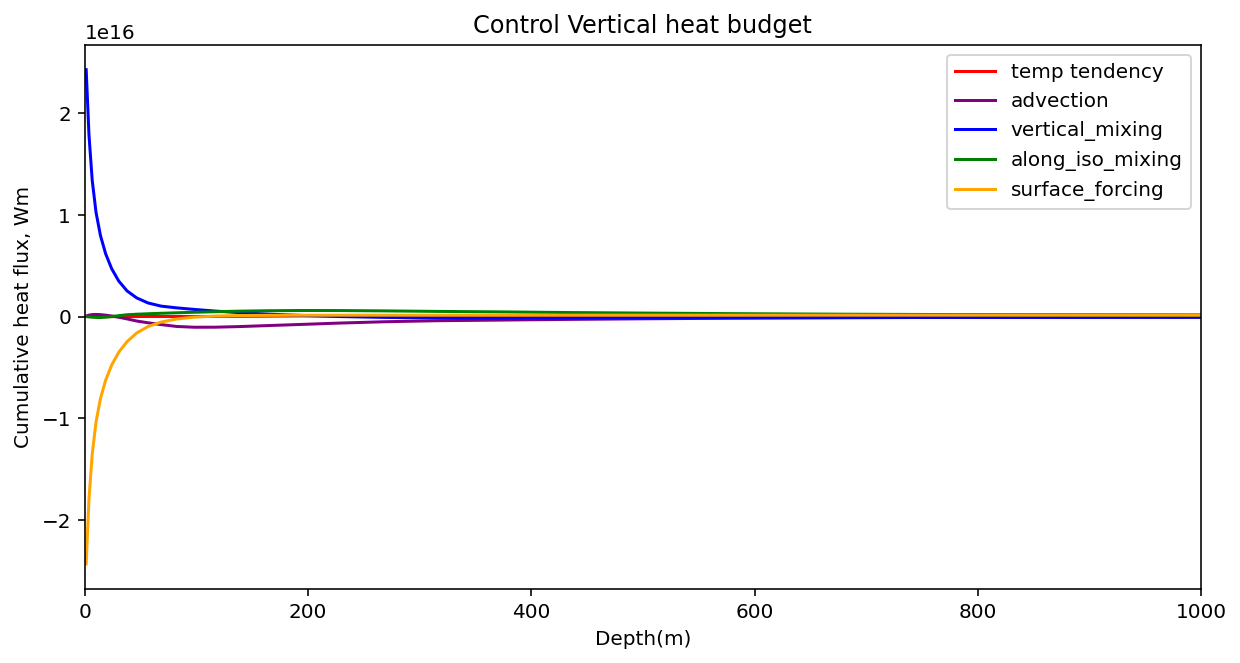

In [5]:
i = 30
ax = plt.figure(figsize=(10,5))
temp_tendency_warm, advection_warm, vertical_mixing_warm, along_iso_mixing_warm, surface_forcing_combined_warm, area_t = vertical_heat_budget_terms('Warming')

((temp_tendency_warm*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'temp tendency', color = 'r')
((advection_warm*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'advection', color = 'purple')
((vertical_mixing_warm*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'vertical_mixing', color = 'blue')
((along_iso_mixing_warm*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'along_iso_mixing',color = 'green')
((surface_forcing_combined_warm*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'surface_forcing', color ='orange')

plt.legend()
plt.xlim(0,1000)
plt.xlabel('Depth(m)')
plt.ylabel('Cumulative heat flux, Wm')
plt.title('Control Vertical heat budget')

plt.savefig('budget')

Text(0.5, 1.0, 'Vertical heat budget anomalies over 50 years')

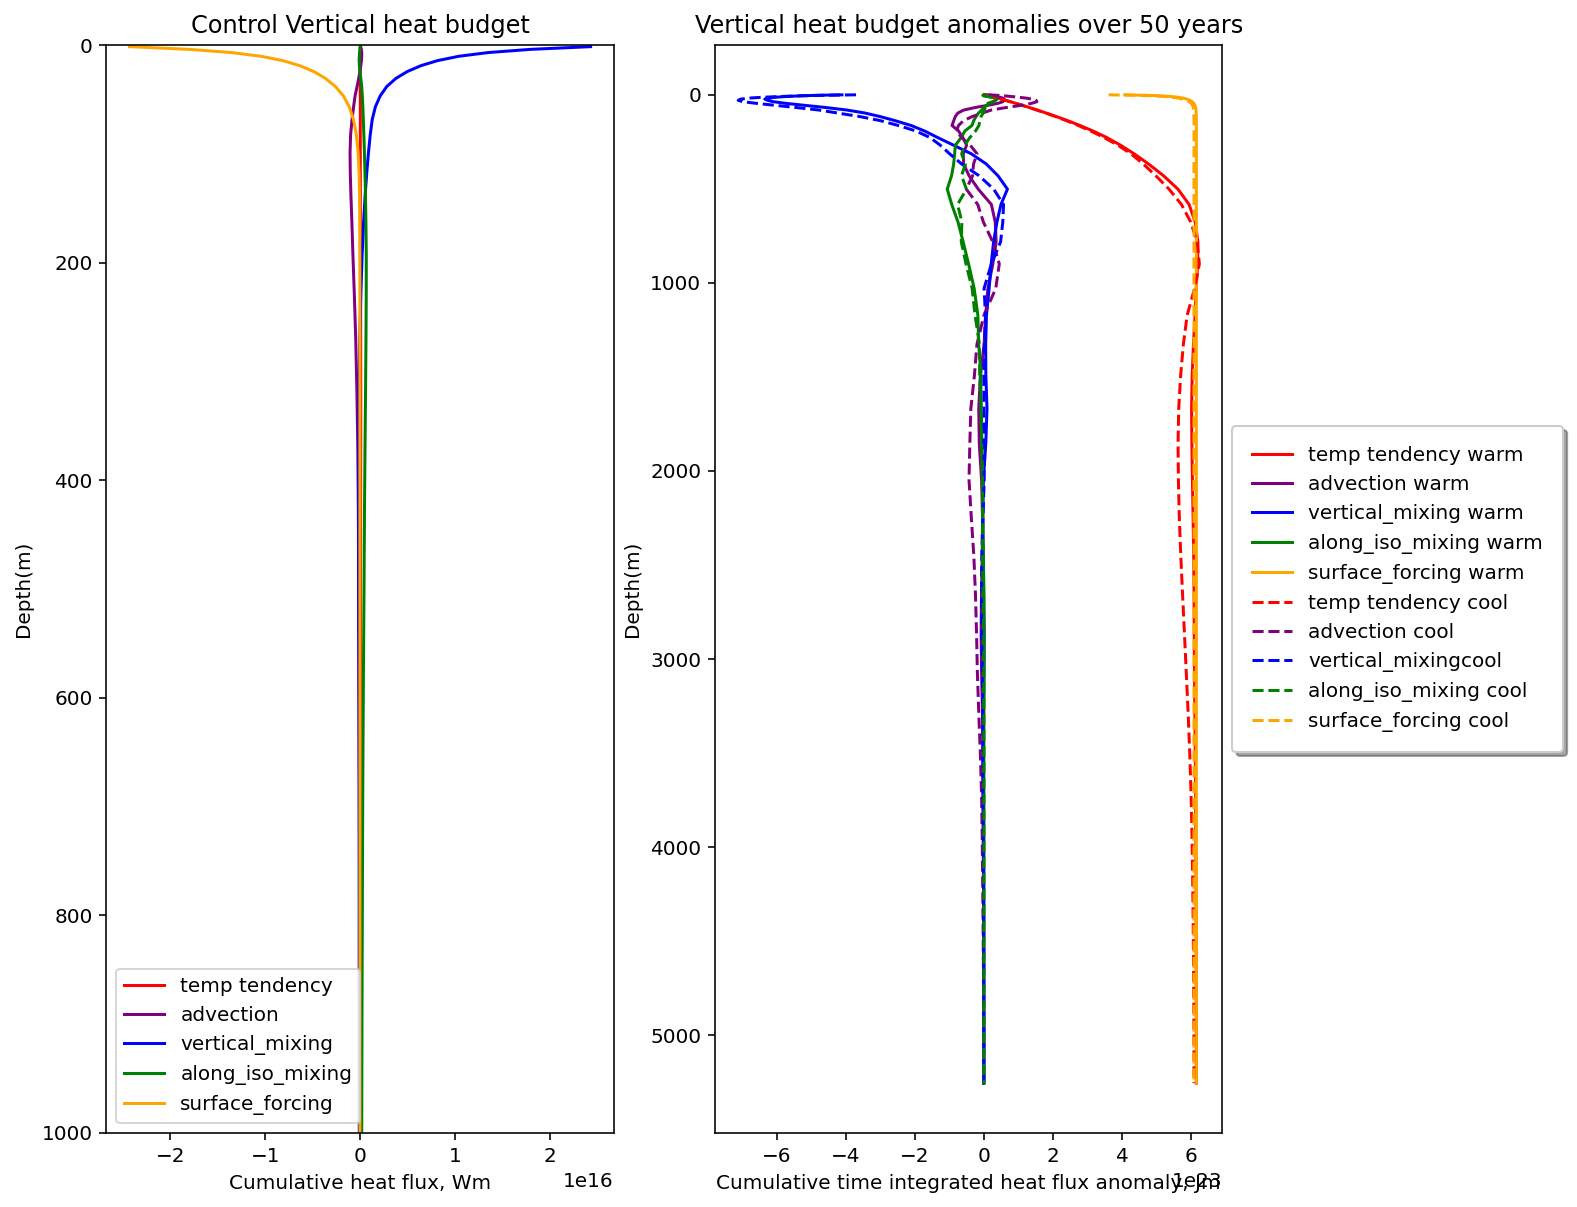

In [7]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (10,10))
i = 30
temp_tendency_warm, advection_warm, vertical_mixing_warm, along_iso_mixing_warm, surface_forcing_combined_warm, area_t = vertical_heat_budget_terms('Control')

((temp_tendency_warm*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(ax =axes[0],y = 'st_ocean', label = 'temp tendency', color = 'r', yincrease = False)
((advection_warm*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(ax =axes[0],y = 'st_ocean',label = 'advection', color = 'purple', yincrease = False)
((vertical_mixing_warm*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(ax =axes[0],y = 'st_ocean',label = 'vertical_mixing', color = 'blue', yincrease = False)
((along_iso_mixing_warm*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(ax =axes[0],y = 'st_ocean',label = 'along_iso_mixing',color = 'green', yincrease = False)
((surface_forcing_combined_warm*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(ax =axes[0],y = 'st_ocean',label = 'surface_forcing', color ='orange', yincrease = False)

axes[0].legend()
axes[0].set_ylim(1000,0)
axes[0].set_ylabel('Depth(m)')
axes[0].set_xlabel('Cumulative heat flux, Wm')
axes[0].set_title('Control Vertical heat budget')

month_length = temp_tendency_warm.time.dt.days_in_month

temp_tendency_warm, advection_warm, vertical_mixing_warm, along_iso_mixing_warm, surface_forcing_combined_warm, area_t = vertical_heat_budget_terms('Warming')
temp_tendency_cont, advection_cont, vertical_mixing_cont, along_iso_mixing_cont, surface_forcing_combined_cont, area_t = vertical_heat_budget_terms('Control')

(((temp_tendency_warm-temp_tendency_cont)*area_t*month_length*24*3600)).sum('xt_ocean').sum('yt_ocean').sum('time').cumsum('st_ocean').plot(ax =axes[1],y = 'st_ocean',label = 'temp tendency warm', color = 'r', yincrease = False)
(((advection_warm-advection_cont)*area_t)*month_length*24*3600).sum('xt_ocean').sum('yt_ocean').sum('time').cumsum('st_ocean').plot(ax =axes[1],y = 'st_ocean',label = 'advection warm', color = 'purple', yincrease = False)
(((vertical_mixing_warm-vertical_mixing_cont)*area_t)*month_length*24*3600).sum('xt_ocean').sum('yt_ocean').sum('time').cumsum('st_ocean').plot(ax =axes[1],y = 'st_ocean',label = 'vertical_mixing warm', color = 'blue', yincrease = False)
(((along_iso_mixing_warm-along_iso_mixing_cont)*area_t)*month_length*24*3600).sum('xt_ocean').sum('yt_ocean').sum('time').cumsum('st_ocean').plot(ax =axes[1],y = 'st_ocean',label = 'along_iso_mixing warm', color = 'green', yincrease = False)
(((surface_forcing_combined_warm-surface_forcing_combined_cont)*area_t)*month_length*24*3600).sum('xt_ocean').sum('yt_ocean').sum('time').cumsum('st_ocean').plot(ax =axes[1],y = 'st_ocean',label = 'surface_forcing warm', color = 'orange', yincrease = False)


temp_tendency_warm, advection_warm, vertical_mixing_warm, along_iso_mixing_warm, surface_forcing_combined_warm, area_t = vertical_heat_budget_terms('Cooling')

((-1*(temp_tendency_warm-temp_tendency_cont)*area_t)*month_length*24*3600).sum('xt_ocean').sum('yt_ocean').sum('time').cumsum('st_ocean').plot(ax =axes[1],y = 'st_ocean',label = 'temp tendency cool', linestyle = '--',color = 'r', yincrease = False)
((-1*(advection_warm-advection_cont)*area_t)*month_length*24*3600).sum('xt_ocean').sum('yt_ocean').sum('time').cumsum('st_ocean').plot(ax =axes[1],y = 'st_ocean',label = 'advection cool', linestyle = '--', color = 'purple', yincrease = False)
((-1*(vertical_mixing_warm-vertical_mixing_cont)*area_t)*month_length*24*3600).sum('xt_ocean').sum('yt_ocean').sum('time').cumsum('st_ocean').plot(ax =axes[1],y = 'st_ocean',label = 'vertical_mixingcool', linestyle = '--', color = 'blue', yincrease = False)
((-1*(along_iso_mixing_warm-along_iso_mixing_cont)*area_t)*month_length*24*3600).sum('xt_ocean').sum('yt_ocean').sum('time').cumsum('st_ocean').plot(ax =axes[1],y = 'st_ocean',label = 'along_iso_mixing cool', linestyle = '--', color = 'green', yincrease = False)
((-1*(surface_forcing_combined_warm-surface_forcing_combined_cont)*area_t)*month_length*24*3600).sum('xt_ocean').sum('yt_ocean').sum('time').cumsum('st_ocean').plot(ax =axes[1],y = 'st_ocean',label = 'surface_forcing cool', linestyle = '--', color = 'orange', yincrease = False)
axes[1].legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(1, 0.5),loc = 'center left')
axes[1].set_ylabel('Depth(m)')
axes[1].set_xlabel('Cumulative time integrated heat flux anomaly, Jm')
axes[1].set_title('Vertical heat budget anomalies over 50 years')


Text(0.5, 1.0, '(b) Vertical heat budget anomalies over 50 years')

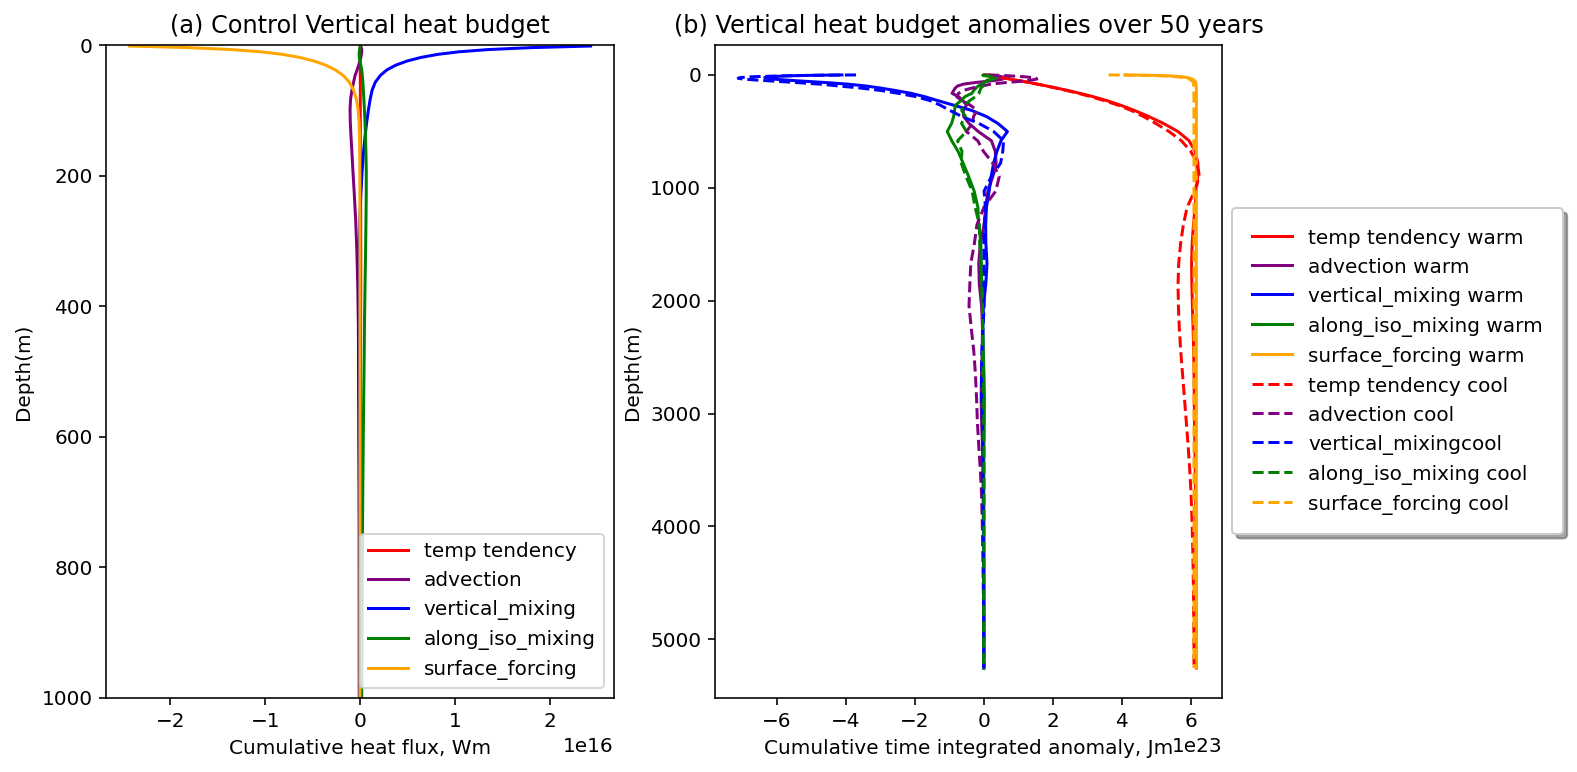

In [8]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (10,6))
i = 30
temp_tendency_warm, advection_warm, vertical_mixing_warm, along_iso_mixing_warm, surface_forcing_combined_warm, area_t = vertical_heat_budget_terms('Control')

((temp_tendency_warm*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(ax =axes[0],y = 'st_ocean', label = 'temp tendency', color = 'r', yincrease = False)
((advection_warm*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(ax =axes[0],y = 'st_ocean',label = 'advection', color = 'purple', yincrease = False)
((vertical_mixing_warm*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(ax =axes[0],y = 'st_ocean',label = 'vertical_mixing', color = 'blue', yincrease = False)
((along_iso_mixing_warm*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(ax =axes[0],y = 'st_ocean',label = 'along_iso_mixing',color = 'green', yincrease = False)
((surface_forcing_combined_warm*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(ax =axes[0],y = 'st_ocean',label = 'surface_forcing', color ='orange', yincrease = False)

axes[0].legend()
axes[0].set_ylim(1000,0)
axes[0].set_ylabel('Depth(m)')
axes[0].set_xlabel('Cumulative heat flux, Wm')
axes[0].set_title('(a) Control Vertical heat budget')

month_length = temp_tendency_warm.time.dt.days_in_month

temp_tendency_warm, advection_warm, vertical_mixing_warm, along_iso_mixing_warm, surface_forcing_combined_warm, area_t = vertical_heat_budget_terms('Warming')
temp_tendency_cont, advection_cont, vertical_mixing_cont, along_iso_mixing_cont, surface_forcing_combined_cont, area_t = vertical_heat_budget_terms('Control')

(((temp_tendency_warm-temp_tendency_cont)*area_t*month_length*24*3600)).sum('xt_ocean').sum('yt_ocean').sum('time').cumsum('st_ocean').plot(ax =axes[1],y = 'st_ocean',label = 'temp tendency warm', color = 'r', yincrease = False)
(((advection_warm-advection_cont)*area_t)*month_length*24*3600).sum('xt_ocean').sum('yt_ocean').sum('time').cumsum('st_ocean').plot(ax =axes[1],y = 'st_ocean',label = 'advection warm', color = 'purple', yincrease = False)
(((vertical_mixing_warm-vertical_mixing_cont)*area_t)*month_length*24*3600).sum('xt_ocean').sum('yt_ocean').sum('time').cumsum('st_ocean').plot(ax =axes[1],y = 'st_ocean',label = 'vertical_mixing warm', color = 'blue', yincrease = False)
(((along_iso_mixing_warm-along_iso_mixing_cont)*area_t)*month_length*24*3600).sum('xt_ocean').sum('yt_ocean').sum('time').cumsum('st_ocean').plot(ax =axes[1],y = 'st_ocean',label = 'along_iso_mixing warm', color = 'green', yincrease = False)
(((surface_forcing_combined_warm-surface_forcing_combined_cont)*area_t)*month_length*24*3600).sum('xt_ocean').sum('yt_ocean').sum('time').cumsum('st_ocean').plot(ax =axes[1],y = 'st_ocean',label = 'surface_forcing warm', color = 'orange', yincrease = False)


temp_tendency_warm, advection_warm, vertical_mixing_warm, along_iso_mixing_warm, surface_forcing_combined_warm, area_t = vertical_heat_budget_terms('Cooling')

((-1*(temp_tendency_warm-temp_tendency_cont)*area_t)*month_length*24*3600).sum('xt_ocean').sum('yt_ocean').sum('time').cumsum('st_ocean').plot(ax =axes[1],y = 'st_ocean',label = 'temp tendency cool', linestyle = '--',color = 'r', yincrease = False)
((-1*(advection_warm-advection_cont)*area_t)*month_length*24*3600).sum('xt_ocean').sum('yt_ocean').sum('time').cumsum('st_ocean').plot(ax =axes[1],y = 'st_ocean',label = 'advection cool', linestyle = '--', color = 'purple', yincrease = False)
((-1*(vertical_mixing_warm-vertical_mixing_cont)*area_t)*month_length*24*3600).sum('xt_ocean').sum('yt_ocean').sum('time').cumsum('st_ocean').plot(ax =axes[1],y = 'st_ocean',label = 'vertical_mixingcool', linestyle = '--', color = 'blue', yincrease = False)
((-1*(along_iso_mixing_warm-along_iso_mixing_cont)*area_t)*month_length*24*3600).sum('xt_ocean').sum('yt_ocean').sum('time').cumsum('st_ocean').plot(ax =axes[1],y = 'st_ocean',label = 'along_iso_mixing cool', linestyle = '--', color = 'green', yincrease = False)
((-1*(surface_forcing_combined_warm-surface_forcing_combined_cont)*area_t)*month_length*24*3600).sum('xt_ocean').sum('yt_ocean').sum('time').cumsum('st_ocean').plot(ax =axes[1],y = 'st_ocean',label = 'surface_forcing cool', linestyle = '--', color = 'orange', yincrease = False)
axes[1].legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(1, 0.5),loc = 'center left')
axes[1].set_ylabel('Depth(m)')
axes[1].set_xlabel('Cumulative time integrated anomaly, Jm')
axes[1].set_title('(b) Vertical heat budget anomalies over 50 years')


distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.core - ERROR - 'tcp://127.0.0.1:42567'
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/distributed/core.py", line 563, in handle_stream
    handler(**merge(extra, msg))
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/distributed/scheduler.py", line 3359, in handle_release_data
    ws: WorkerState = self.workers[worker]
KeyError: 'tcp://127.0.0.1:42567'
distributed.utils - ERROR - 'tcp://127.0.0.1:42567'
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/distributed/utils.py", line 655, in log_errors
    yield
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/

KilledWorker: ("('open_dataset-concatenate-fd1d3ab3b783a39061b0f7c4089f35a5', 483, 0, 0, 0)", <Worker 'tcp://127.0.0.1:46827', name: 0, memory: 0, processing: 4469>)

distributed.nanny - WARNING - Restarting worker


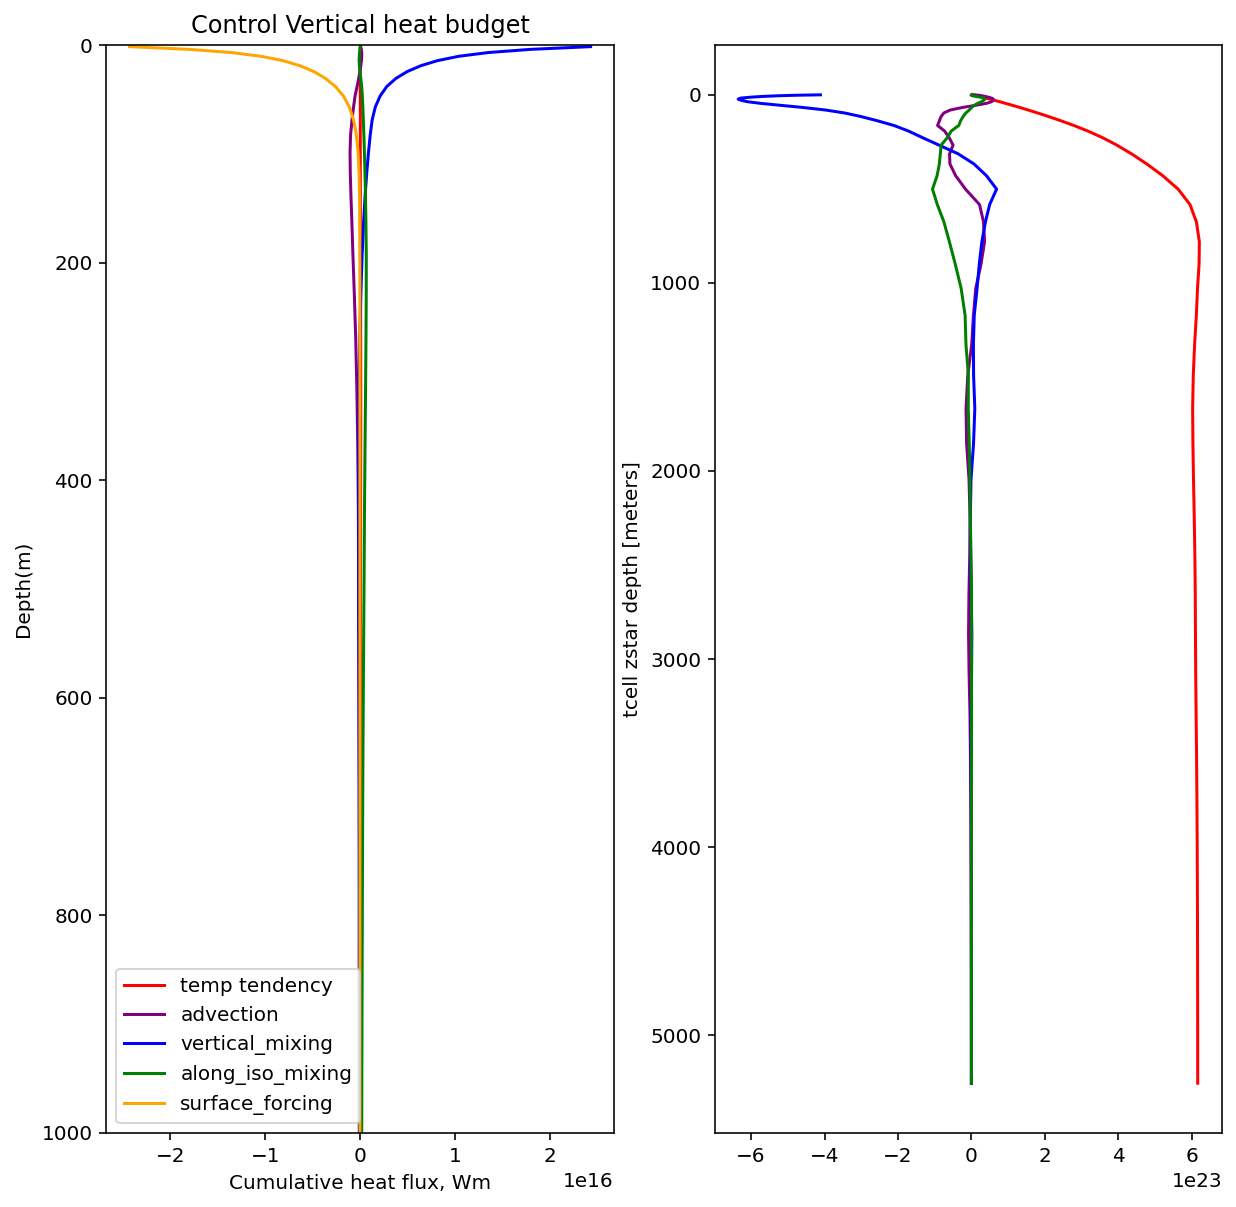

In [8]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (10,10))
i = 30
temp_tendency_warm, advection_warm, vertical_mixing_warm, along_iso_mixing_warm, surface_forcing_combined_warm, area_t = vertical_heat_budget_terms('Control')

((temp_tendency_warm*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(ax =axes[0],y = 'st_ocean', label = 'temp tendency', color = 'r', yincrease = False)
((advection_warm*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(ax =axes[0],y = 'st_ocean',label = 'advection', color = 'purple', yincrease = False)
((vertical_mixing_warm*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(ax =axes[0],y = 'st_ocean',label = 'vertical_mixing', color = 'blue', yincrease = False)
((along_iso_mixing_warm*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(ax =axes[0],y = 'st_ocean',label = 'along_iso_mixing',color = 'green', yincrease = False)
((surface_forcing_combined_warm*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(ax =axes[0],y = 'st_ocean',label = 'surface_forcing', color ='orange', yincrease = False)

axes[0].legend()
axes[0].set_ylim(1000,0)
axes[0].set_ylabel('Depth(m)')
axes[0].set_xlabel('Cumulative heat flux, Wm')
axes[0].set_title('Control vertical heat budget')

month_length = temp_tendency_warm.time.dt.days_in_month

temp_tendency_warm, advection_warm, vertical_mixing_warm, along_iso_mixing_warm, surface_forcing_combined_warm, area_t = vertical_heat_budget_terms('Warming')
temp_tendency_cont, advection_cont, vertical_mixing_cont, along_iso_mixing_cont, surface_forcing_combined_cont, area_t = vertical_heat_budget_terms('Control')

(((temp_tendency_warm-temp_tendency_cont)*area_t*month_length*24*3600)).sum('xt_ocean').sum('yt_ocean').sum('time').cumsum('st_ocean').plot(ax =axes[1],y = 'st_ocean',label = 'temp tendency warm', color = 'r', yincrease = False)
(((advection_warm-advection_cont)*area_t)*month_length*24*3600).sum('xt_ocean').sum('yt_ocean').sum('time').cumsum('st_ocean').plot(ax =axes[1],y = 'st_ocean',label = 'advection warm', color = 'purple', yincrease = False)
(((vertical_mixing_warm-vertical_mixing_cont)*area_t)*month_length*24*3600).sum('xt_ocean').sum('yt_ocean').sum('time').cumsum('st_ocean').plot(ax =axes[1],y = 'st_ocean',label = 'vertical_mixing warm', color = 'blue', yincrease = False)
(((along_iso_mixing_warm-along_iso_mixing_cont)*area_t)*month_length*24*3600).sum('xt_ocean').sum('yt_ocean').sum('time').cumsum('st_ocean').plot(ax =axes[1],y = 'st_ocean',label = 'along_iso_mixing warm', color = 'green', yincrease = False)
(((surface_forcing_combined_warm-surface_forcing_combined_cont)*area_t)*month_length*24*3600).sum('xt_ocean').sum('yt_ocean').sum('time').cumsum('st_ocean').plot(ax =axes[1],y = 'st_ocean',label = 'surface_forcing warm', color = 'orange', yincrease = False)


temp_tendency_warm, advection_warm, vertical_mixing_warm, along_iso_mixing_warm, surface_forcing_combined_warm, area_t = vertical_heat_budget_terms('Cooling')

((-1*(temp_tendency_warm-temp_tendency_cont)*area_t)*month_length*24*3600).sum('xt_ocean').sum('yt_ocean').sum('time').cumsum('st_ocean').plot(ax =axes[1],y = 'st_ocean',label = 'temp tendency cool', linestyle = '--',color = 'r', yincrease = False)
((-1*(advection_warm-advection_cont)*area_t)*month_length*24*3600).sum('xt_ocean').sum('yt_ocean').sum('time').cumsum('st_ocean').plot(ax =axes[1],y = 'st_ocean',label = 'advection cool', linestyle = '--', color = 'purple', yincrease = False)
((-1*(vertical_mixing_warm-vertical_mixing_cont)*area_t)*month_length*24*3600).sum('xt_ocean').sum('yt_ocean').sum('time').cumsum('st_ocean').plot(ax =axes[1],y = 'st_ocean',label = 'vertical_mixingcool', linestyle = '--', color = 'blue', yincrease = False)
((-1*(along_iso_mixing_warm-along_iso_mixing_cont)*area_t)*month_length*24*3600).sum('xt_ocean').sum('yt_ocean').sum('time').cumsum('st_ocean').plot(ax =axes[1],y = 'st_ocean',label = 'along_iso_mixing cool', linestyle = '--', color = 'green', yincrease = False)
((-1*(surface_forcing_combined_warm-surface_forcing_combined_cont)*area_t)*month_length*24*3600).sum('xt_ocean').sum('yt_ocean').sum('time').cumsum('st_ocean').plot(ax =axes[1],y = 'st_ocean',label = 'surface_forcing cool', linestyle = '--', color = 'orange', yincrease = False)
axes[1].legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(1, 0.5),loc = 'center left')
axes[1].set_ylabel('Depth(m)')
axes[1].set_xlabel('Cumulative time integrated heat flux anomaly, Jm')
axes[1].set_title('Vertical heat budget anomalies over 50 years')


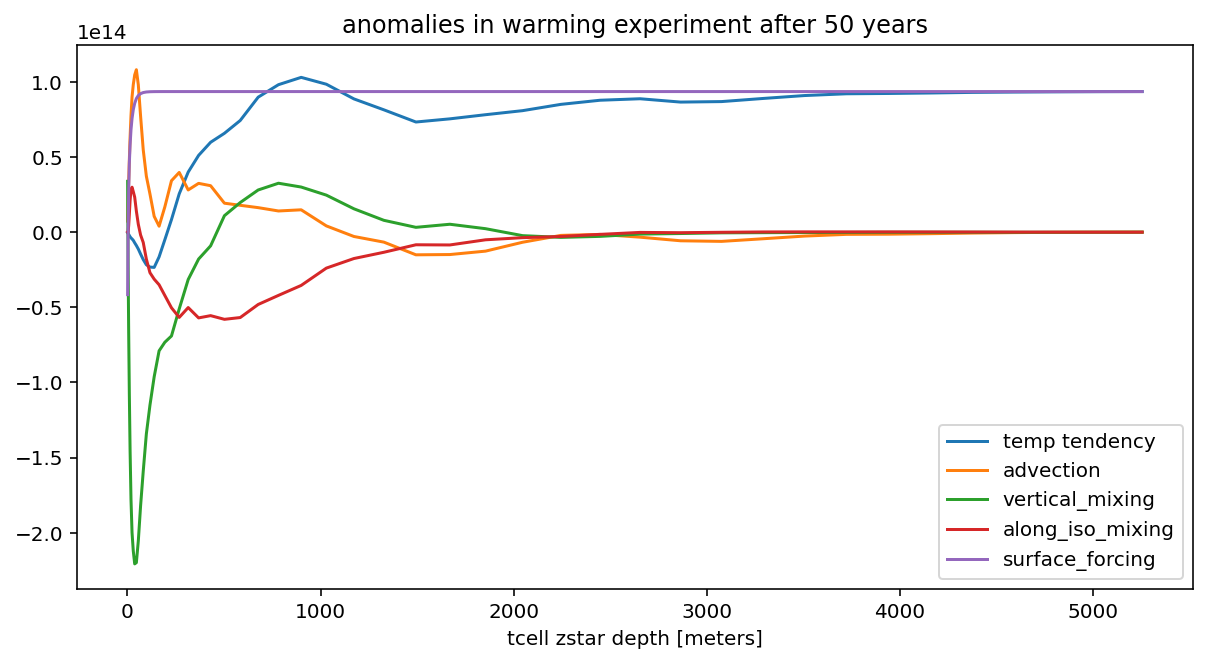

In [6]:
i = 49
ax = plt.figure(figsize=(10,5))
temp_tendency_warm, advection_warm, vertical_mixing_warm, along_iso_mixing_warm, surface_forcing_combined_warm, area_t = vertical_heat_budget_terms('Warming')
temp_tendency_cont, advection_cont, vertical_mixing_cont, along_iso_mixing_cont, surface_forcing_combined_cont, area_t = vertical_heat_budget_terms('Control')

(((temp_tendency_warm-temp_tendency_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'temp tendency')
(((advection_warm-advection_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'advection')
(((vertical_mixing_warm-vertical_mixing_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'vertical_mixing')
(((along_iso_mixing_warm-along_iso_mixing_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'along_iso_mixing')
(((surface_forcing_combined_warm-surface_forcing_combined_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'surface_forcing')
plt.title('anomalies in warming experiment after 50 years')
plt.legend()
#plt.xlim(0,1000)

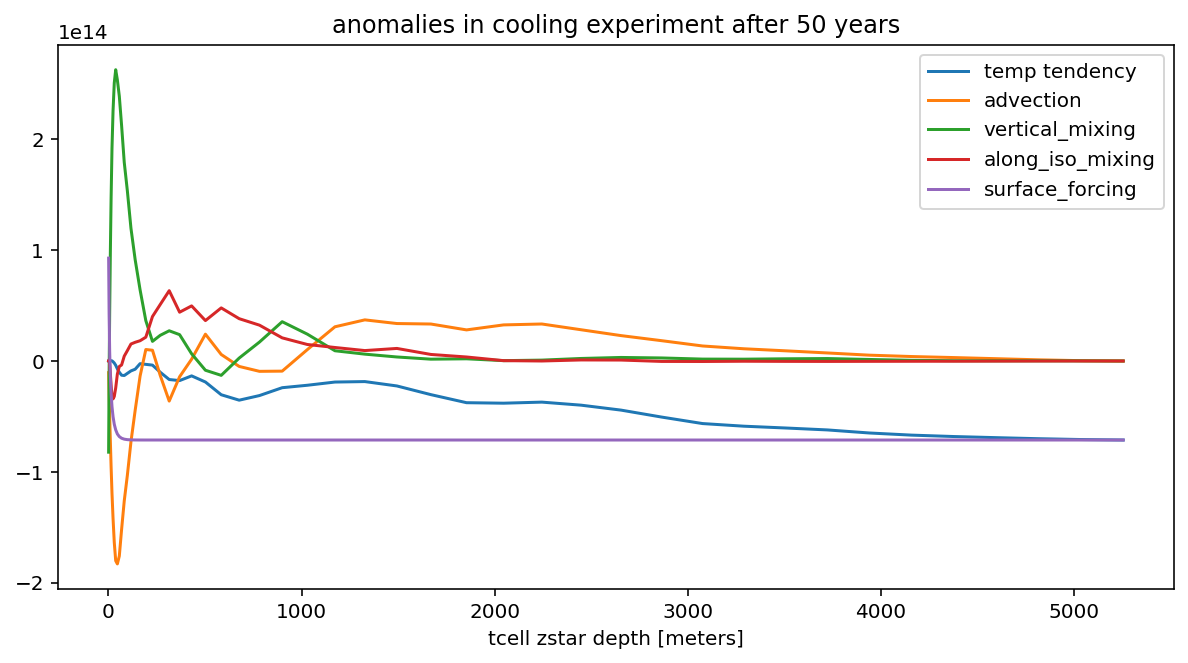

In [7]:
i = 49
ax = plt.figure(figsize=(10,5))
temp_tendency_warm, advection_warm, vertical_mixing_warm, along_iso_mixing_warm, surface_forcing_combined_warm, area_t = vertical_heat_budget_terms('Cooling')
temp_tendency_cont, advection_cont, vertical_mixing_cont, along_iso_mixing_cont, surface_forcing_combined_cont, area_t = vertical_heat_budget_terms('Control')

(((temp_tendency_warm-temp_tendency_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'temp tendency')
(((advection_warm-advection_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'advection')
(((vertical_mixing_warm-vertical_mixing_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'vertical_mixing')
(((along_iso_mixing_warm-along_iso_mixing_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'along_iso_mixing')
(((surface_forcing_combined_warm-surface_forcing_combined_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'surface_forcing')
plt.title('anomalies in cooling experiment after 50 years')
plt.legend()
#plt.xlim(0,1000)

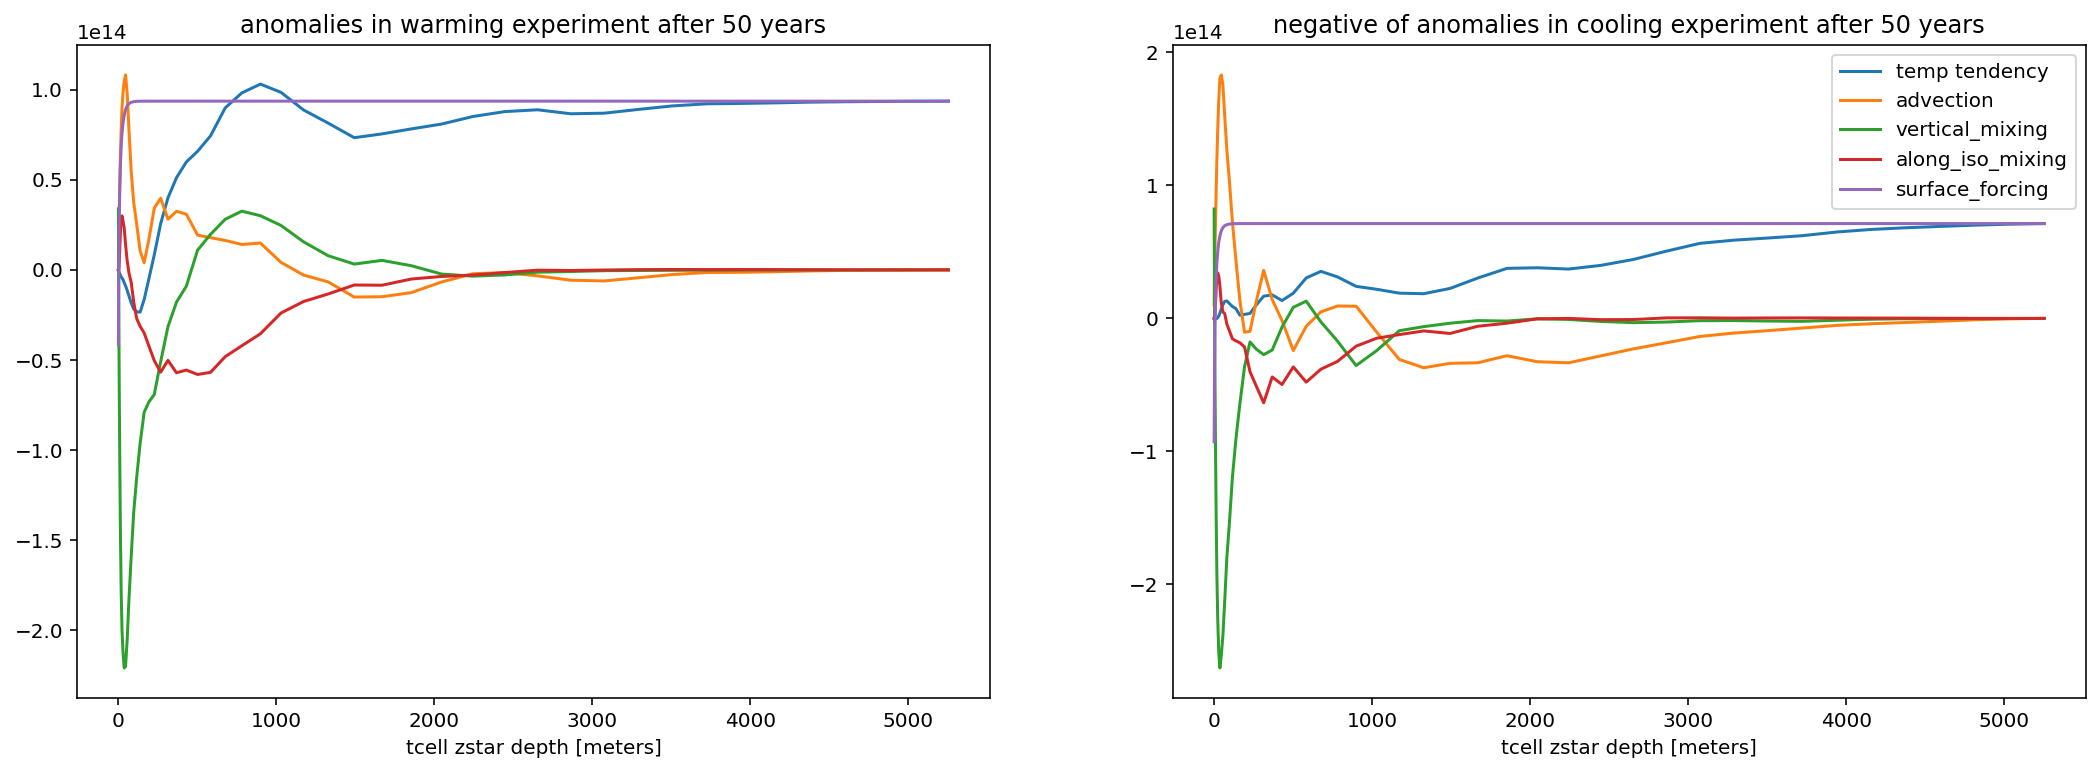

In [8]:
i = 49
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (18,6))
temp_tendency_warm, advection_warm, vertical_mixing_warm, along_iso_mixing_warm, surface_forcing_combined_warm, area_t = vertical_heat_budget_terms('Warming')
temp_tendency_cont, advection_cont, vertical_mixing_cont, along_iso_mixing_cont, surface_forcing_combined_cont, area_t = vertical_heat_budget_terms('Control')

(((temp_tendency_warm-temp_tendency_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'temp tendency', ax = axes[0])
(((advection_warm-advection_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'advection', ax = axes[0])
(((vertical_mixing_warm-vertical_mixing_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'vertical_mixing', ax = axes[0])
(((along_iso_mixing_warm-along_iso_mixing_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'along_iso_mixing', ax = axes[0])
(((surface_forcing_combined_warm-surface_forcing_combined_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'surface_forcing', ax = axes[0])
axes[0].set_title('anomalies in warming experiment after 50 years')

temp_tendency_warm, advection_warm, vertical_mixing_warm, along_iso_mixing_warm, surface_forcing_combined_warm, area_t = vertical_heat_budget_terms('Cooling')

((-1*(temp_tendency_warm-temp_tendency_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'temp tendency', ax = axes[1])
((-1*(advection_warm-advection_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'advection', ax = axes[1])
((-1*(vertical_mixing_warm-vertical_mixing_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'vertical_mixing', ax = axes[1])
((-1*(along_iso_mixing_warm-along_iso_mixing_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'along_iso_mixing', ax = axes[1])
((-1*(surface_forcing_combined_warm-surface_forcing_combined_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'surface_forcing', ax = axes[1])
axes[1].set_title('negative of anomalies in cooling experiment after 50 years')

plt.legend()
#plt.xlim(0,1000)

very crude sum('time') - need to multiply by no. seconds in each month.

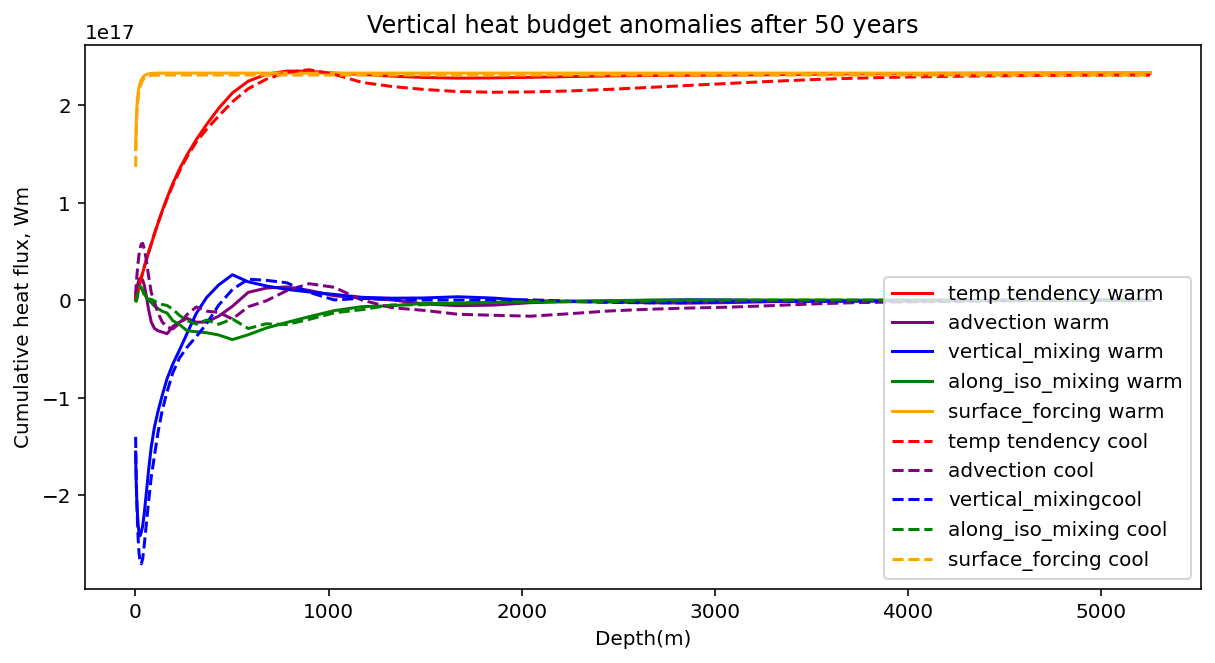

In [7]:
i = 49
ax = plt.figure(figsize=(10,5))

temp_tendency_warm, advection_warm, vertical_mixing_warm, along_iso_mixing_warm, surface_forcing_combined_warm, area_t = vertical_heat_budget_terms('Warming')
temp_tendency_cont, advection_cont, vertical_mixing_cont, along_iso_mixing_cont, surface_forcing_combined_cont, area_t = vertical_heat_budget_terms('Control')

(((temp_tendency_warm-temp_tendency_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).sum('time').cumsum('st_ocean').plot(label = 'temp tendency warm', color = 'r')
(((advection_warm-advection_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).sum('time').cumsum('st_ocean').plot(label = 'advection warm', color = 'purple')
(((vertical_mixing_warm-vertical_mixing_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).sum('time').cumsum('st_ocean').plot(label = 'vertical_mixing warm', color = 'blue')
(((along_iso_mixing_warm-along_iso_mixing_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).sum('time').cumsum('st_ocean').plot(label = 'along_iso_mixing warm', color = 'green')
(((surface_forcing_combined_warm-surface_forcing_combined_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).sum('time').cumsum('st_ocean').plot(label = 'surface_forcing warm', color = 'orange')
plt.title('anomalies in perturbation experiment after 50 years')


temp_tendency_warm, advection_warm, vertical_mixing_warm, along_iso_mixing_warm, surface_forcing_combined_warm, area_t = vertical_heat_budget_terms('Cooling')

((-1*(temp_tendency_warm-temp_tendency_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).sum('time').cumsum('st_ocean').plot(label = 'temp tendency cool', linestyle = '--',color = 'r')
((-1*(advection_warm-advection_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).sum('time').cumsum('st_ocean').plot(label = 'advection cool', linestyle = '--', color = 'purple')
((-1*(vertical_mixing_warm-vertical_mixing_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).sum('time').cumsum('st_ocean').plot(label = 'vertical_mixingcool', linestyle = '--', color = 'blue')
((-1*(along_iso_mixing_warm-along_iso_mixing_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).sum('time').cumsum('st_ocean').plot(label = 'along_iso_mixing cool', linestyle = '--', color = 'green')
((-1*(surface_forcing_combined_warm-surface_forcing_combined_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).sum('time').cumsum('st_ocean').plot(label = 'surface_forcing cool', linestyle = '--', color = 'orange')
plt.legend()
plt.xlabel('Depth(m)')
plt.ylabel('Cumulative heat flux, Wm')
plt.title('Vertical heat budget anomalies after 50 years')
plt.savefig('Heat_budget_anomaly')
#plt.xlim(0,1000)

^^^^ An estimation of the time integral vertically cumulative heat flux, so in units of Jm. temp tendency looks similar to integral of vertical temperature profile, cold assymetry with stronger warming signals. It also took like an hour to compute :(

main difference in advective terms. cooling has the larger magnitude anomaly. it is interesting that the temp tendencies are so different too.

positive numbers mean heat going down. so there is more heat going UP in the cooling one than heat going DOWN in the warming one. Makes sense due to MOC change?

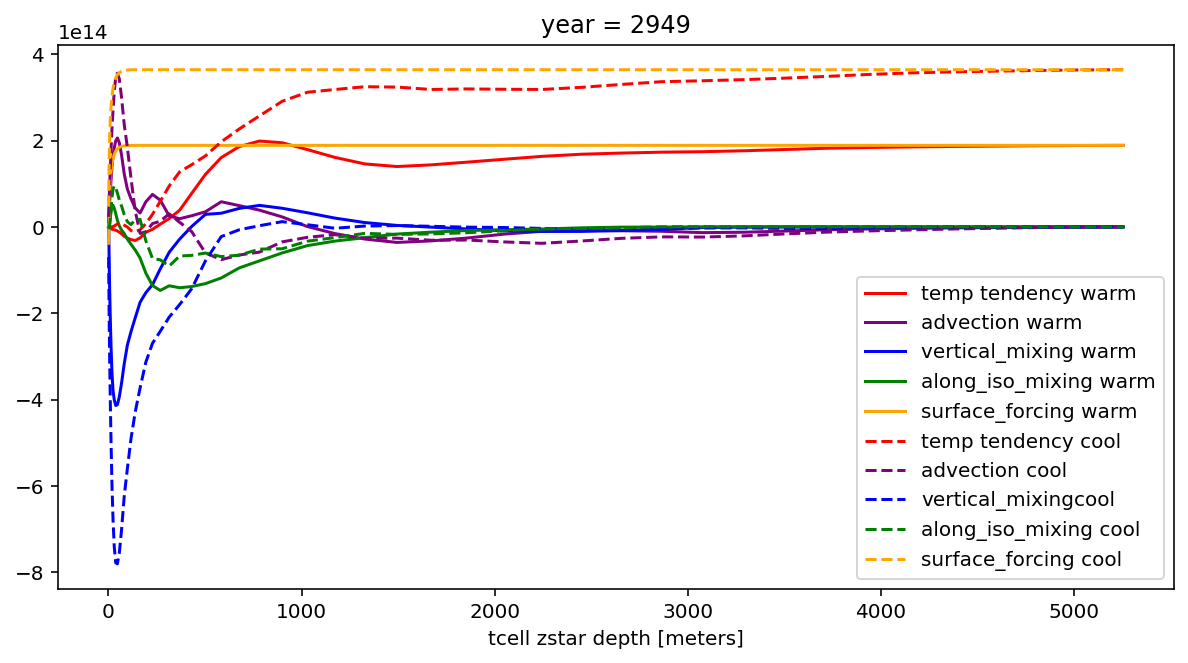

In [10]:
i = 49
ax = plt.figure(figsize=(10,5))

temp_tendency_warm, advection_warm, vertical_mixing_warm, along_iso_mixing_warm, surface_forcing_combined_warm, area_t = vertical_heat_budget_terms('Warming x2')
temp_tendency_cont, advection_cont, vertical_mixing_cont, along_iso_mixing_cont, surface_forcing_combined_cont, area_t = vertical_heat_budget_terms('Control')

(((temp_tendency_warm-temp_tendency_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'temp tendency warm', color = 'r')
(((advection_warm-advection_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'advection warm', color = 'purple')
(((vertical_mixing_warm-vertical_mixing_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'vertical_mixing warm', color = 'blue')
(((along_iso_mixing_warm-along_iso_mixing_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'along_iso_mixing warm', color = 'green')
(((surface_forcing_combined_warm-surface_forcing_combined_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'surface_forcing warm', color = 'orange')
plt.title('anomalies in perturbation experiment after 50 years, double forcings')


temp_tendency_warm, advection_warm, vertical_mixing_warm, along_iso_mixing_warm, surface_forcing_combined_warm, area_t = vertical_heat_budget_terms('Cooling x2')

((-1*(temp_tendency_warm-temp_tendency_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'temp tendency cool', linestyle = '--',color = 'r')
((-1*(advection_warm-advection_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'advection cool', linestyle = '--', color = 'purple')
((-1*(vertical_mixing_warm-vertical_mixing_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'vertical_mixingcool', linestyle = '--', color = 'blue')
((-1*(along_iso_mixing_warm-along_iso_mixing_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'along_iso_mixing cool', linestyle = '--', color = 'green')
((-1*(surface_forcing_combined_warm-surface_forcing_combined_cont)*area_t).sum('xt_ocean').sum('yt_ocean')).groupby('time.year').mean('time').isel(year = i).cumsum('st_ocean').plot(label = 'surface_forcing cool', linestyle = '--', color = 'orange')
plt.legend()
#plt.xlim(0,1000)

in the double cooling experiment the difference is more obvious in the vertical mixing terms.